In [5]:
import pandas as pd
import numpy as np
import scipy.stats as stat
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math

In [6]:
import textdistance
import string
from sklearn.cluster import DBSCAN

In [7]:
df_canvass = pd.read_csv("data/canvass_records.csv.gz")
print("Read {} records.".format(len(df_canvass)))

Read 50462 records.


In [8]:
df_complaint = pd.read_csv("data/complaint_records.csv.gz")
print("Read {} records.".format(len(df_complaint)))

Read 17088 records.


In [9]:
df_all = pd.concat([df_canvass, df_complaint])
df_all.head()

,inspection_id,address,aka_name,city,dba_name,facility_type,inspection_date,inspection_type,latitude,license_id,...,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
0,1981667,1725 W 47TH ST,BELLAS FUENTEZ,CHICAGO,BELLAS FUENTEZ,Restaurant,2017-01-19T00:00:00.000,Canvass,41.808460,1356217,...,0,0,0,0,0,0,0,0,0,0
1,1453500,65 W JACKSON BLVD,CARVERY,CHICAGO,CARVERY,Restaurant,2014-08-26T00:00:00.000,Canvass,41.878046,43330,...,0,0,0,0,0,0,0,0,0,0
2,1102252,11601 W TOUHY AVE,THE GREAT AMERICAN BAGEL/T3 K2,CHICAGO,THE GREAT AMERICAN BAGEL,Restaurant,2012-05-07T00:00:00.000,Canvass,42.008536,1879167,...,0,0,0,0,0,0,0,0,0,0
3,68091,2804 N CLARK ST,Wells Street Popcorn,CHICAGO,Wells Street Popcorn,Restaurant,2010-02-01T00:00:00.000,Canvass,41.932921,1954774,...,0,0,0,0,0,0,0,0,0,0
4,1482983,1847 W ROSCOE ST,FOUR MOON TAVERN,CHICAGO,FOUR MOON TAVERN,Restaurant,2015-09-14T00:00:00.000,Canvass,41.943141,51644,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df_all["aka_name"] = df_all["aka_name"].fillna("NULL_NAME")

In [11]:
key_col = "license_id"
name_col = "aka_name"
lid_aka = df_all.groupby(key_col)[name_col].unique()
lid_aka.head()
name_df = pd.DataFrame({key_col: lid_aka.index, name_col: lid_aka.values})
name_df["N"] = name_df[name_col].apply(lambda a: len(a))

In [12]:
name_df.sort_values(by="N", ascending=False)[20:30]

,license_id,aka_name,N
9077,2220904,"[STREETERVILLE PIZZERIA & TAP, FLOUR & STONE, ...",3
5324,1893935,"[AQUA BAR & GRILL, TWISTED TAPAS, NULL_NAME]",3
6851,2027309,"[CENTRO, BAR UMBRIAGO, ROSEBUD EATT]",3
96,1806,"[AMBASSADOR PUBLIC HOUSE, BOUZOUKI LOUNGE, AVIVA]",3
5714,1933945,"[NEW REBOZO CHICAGO, CANTINA #46, CANTINA 46]",3
8003,2120365,"[UR INN, Tortuga's Cantina]",2
6774,2021306,"[Chizakaya, ENTENTE]",2
10315,2340467,"[MANZO'S BURGER, FIVE STAR BURGER]",2
4517,1767227,"[I-CAFE, I - CAFE PIDE VE LAHMACUN]",2
11031,2391299,"[ANALOGUE, DAISIES]",2


In [13]:
zoot_all = df_all.groupby(key_col)["inspection_id"].count().sort_values(ascending=False)
dict_all = {name_col: [lid_aka[z] for z in zoot_all.index], "count": zoot_all.values}
zdf_all = pd.DataFrame(dict_all)
zdf_all[20:30]

,aka_name,count
20,[CHURCH'S CHICKEN # 982],22
21,[MAGGIE GYROS & CHICKEN],22
22,[MCDONALD'S],22
23,[DUKS RED HOTS],22
24,[HONG KONG BUFFET],21
25,[MC DONALDS],21
26,[SEE THRU CHINESE RESTAURANT],21
27,[NICKY'S CHINESE FOOD],21
28,[MC DONALDS],21
29,[CHIPOTLE MEXICAN GRILL],21


In [14]:
textdistance.jaro_winkler.similarity("McDONALDS".casefold(), "MCDONALDS RESTAURANT".casefold())

0.89

In [17]:
name_count = df_all.groupby("aka_name")["inspection_id"].count()
names = list(name_count.sort_values(ascending=False).head(500).index)
# names = list(name_count.index)

In [18]:
BANNED = list(string.punctuation) + [
    "restaurant",
    "house",
    "kitchen",
    "original",
    "the",
    "new"
] + [" "]
BANNED = [ban.casefold() for ban in BANNED]
CUT_CHARS = ["#", "("]

def clean_name(name):
    cleaned = name.casefold()
    for cut in CUT_CHARS:
        idx = cleaned.find(cut)
        if idx > 0:
            cleaned = cleaned[:idx]
    for ban in BANNED:
        cleaned = cleaned.replace(ban, "")
    return cleaned


def name_distance(a, b):
    sim = textdistance.jaro_winkler.similarity(a, b)
    dist = 1 - sim
    return dist


RAW_NAMES = np.unique(df_all["aka_name"].values)
NAMES = [clean_name(name) for name in RAW_NAMES]
len(NAMES)

In [20]:
n_clean = 6
print(names[0:n_clean])
print([clean_name(n) for n in names[0:n_clean]])

['SUBWAY', 'DUNKIN DONUTS', "MCDONALD'S", 'NULL_NAME', 'CHIPOTLE MEXICAN GRILL', 'MCDONALDS']
['subway', 'dunkindonuts', 'mcdonalds', 'nullname', 'chipotlemexicangrill', 'mcdonalds']


In [26]:
RAW_NAMES = np.unique(df_all["aka_name"].values)
NAMES = [clean_name(name) for name in RAW_NAMES]
len(NAMES)

10450

In [22]:
def read_distance_matrix(filename):
    chunks = []
    metafile = "models/distance/{}_meta.pkl".format(filename)
    print("Read metadata from {}".format(metafile))
    M, N, size = pickle.load(open(metafile, "rb"))
    for idx, i in enumerate(range(0, N, size)):
        outfile = "models/distance/{0}_{1:02}.pkl".format(filename, idx)
        sub_mat = pickle.load(open(outfile, "rb"))
        chunks.append(sub_mat)
        print("Read {} rows from {}".format(len(sub_mat), outfile))
    res = np.concatenate(chunks)
    for i in range(M):
        for j in range(N):
            if j > i:
                res[j][i] = res[i][j]
            if j == i:
                res[i][j] = 1.0
    return res

In [23]:
dist_mat = read_distance_matrix("aka_name_jw_mat")

Read metadata from models/distance/aka_name_jw_mat_meta.pkl
Read 1000 rows from models/distance/aka_name_jw_mat_00.pkl
Read 1000 rows from models/distance/aka_name_jw_mat_01.pkl
Read 1000 rows from models/distance/aka_name_jw_mat_02.pkl
Read 1000 rows from models/distance/aka_name_jw_mat_03.pkl
Read 1000 rows from models/distance/aka_name_jw_mat_04.pkl
Read 1000 rows from models/distance/aka_name_jw_mat_05.pkl
Read 1000 rows from models/distance/aka_name_jw_mat_06.pkl
Read 1000 rows from models/distance/aka_name_jw_mat_07.pkl
Read 1000 rows from models/distance/aka_name_jw_mat_08.pkl
Read 1000 rows from models/distance/aka_name_jw_mat_09.pkl
Read 450 rows from models/distance/aka_name_jw_mat_10.pkl


In [24]:
type(dist_mat), dist_mat.shape

(numpy.ndarray, (10450, 10450))

In [27]:
pairs = []
for i in range(len(dist_mat)):
    for j in range(len(dist_mat)):
        if j > i:
            pairs.append((i, j, RAW_NAMES[i], RAW_NAMES[j], NAMES[i], NAMES[j], dist_mat[i][j]))

In [29]:
# pd.DataFrame(dist_mat, columns=RAW_NAMES, index=RAW_NAMES).head()

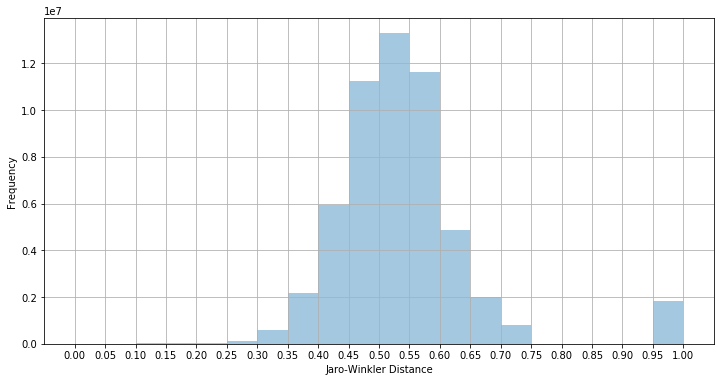

In [35]:
sns.distplot([p[6] for p in pairs], kde=False, bins=np.arange(0, 1.05, 0.05))
plt.xticks(np.arange(0, 1.05, 0.05))
plt.xlabel("Jaro-Winkler Distance")
plt.ylabel("Frequency")
plt.grid()
plt.gcf().set_size_inches(12, 6)
plt.show()

In [ ]:
pair_df = pd.DataFrame(pairs, columns=["i", "j", "a", "b", "a_clean", "b_clean", "dist"])
pair_df.sort_values(by="dist", ascending=False).query("dist >= 0.15 and dist <= 0.18")

In [31]:
dbscan = DBSCAN(eps=0.15, metric="precomputed", min_samples=1)
clusters = dbscan.fit_predict(dist_mat)
len(np.unique(clusters))

911

In [32]:
cluster_dict = {}
for name, cluster in zip(RAW_NAMES, clusters):
    if cluster not in cluster_dict:
        cluster_dict[cluster] = []
    cluster_dict[cluster].append(name)

In [33]:
pickle.dump((RAW_NAMES, clusters), open("models/aka_name_dbscan_clusters.pkl", "wb"))
print("Saved!")

Saved!


In [34]:
pickle.dump(cluster_dict, open("models/aka_name_dbscan_cluster_map.pkl", "wb"))
print("Saved!")

Saved!


In [ ]:
name_dict = {}
for name, cluster in zip(RAW_NAMES, clusters):
    name_dict[name] = cluster

In [ ]:
pickle.dump(name_dict, open("models/aka_name_dbscan_name_map.pkl", "wb"))
print("Saved!")

Saved!


In [ ]:
cdf = pd.DataFrame(cluster_dict.items(), columns=["Cluster", "Restaurants"])
cdf["Names"] = cdf["Restaurants"].apply(lambda a: len(a))
cdf["Inspections"] = cdf["Restaurants"].apply(lambda a: np.sum([name_count[n] for n in a]))
cdf.sort_values(by="Inspections", ascending=False).head(30)

In [ ]:
for r in cdf["Restaurants"].values[:10]:
    print(r)
    print()

In [ ]:
# not_clustered = list(filter(lambda n: n not in names, name_count.index))
# sorted([(n, name_count[n]) for n in not_clustered], key=lambda p: p[1], reverse=True)